# Introduction to Training Image Classification Models

In this notebook, we will give an introduction to using fast.ai for image classification. We will use a small dataset of four differenet beverages to train and evaluate a model. We'll also cover one of the most common ways to store your data in your file system for image classification modelling.

Check out fastai version.

In [4]:
import fastai
from torch.cuda import get_device_name

print(f"Fast.ai: {fastai.__version__}")
print(get_device_name(0))

Fast.ai: 1.0.48
Tesla K80


Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [3]:
import sys
sys.path.append("../")
import numpy as np
from pathlib import Path
from utils_ic.ui_results_viewer import ResultsUI
from utils_ic.datasets import Urls, unzip_url, data_path
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Set some parameters. We'll use the `unzip_url` helper function to download and unzip our data.

In [5]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## File Structure for Image Classification

In this notebook, we'll use images from the `fridge_objects` dataset, which has been downloaded and unzip to  `image_classification/data`.

Lets set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [6]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/git/cvbp/image_classification/data/fridgeObjects/water_bottle'),
 PosixPath('/git/cvbp/image_classification/data/fridgeObjects/can'),
 PosixPath('/git/cvbp/image_classification/data/fridgeObjects/milk_bottle'),
 PosixPath('/git/cvbp/image_classification/data/fridgeObjects/carton')]

You'll notice that we have four different folders inside:
- `/milk_bottle`
- `/carton`
- `/water_bottle`
- `/can`

The most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

Good thing our data is already structured in that format!

## Loading images with fast.ai

To use fastai, we want to create an ImageDataBunch so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

In [7]:
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

Lets take a look at our data using the databunch we created.

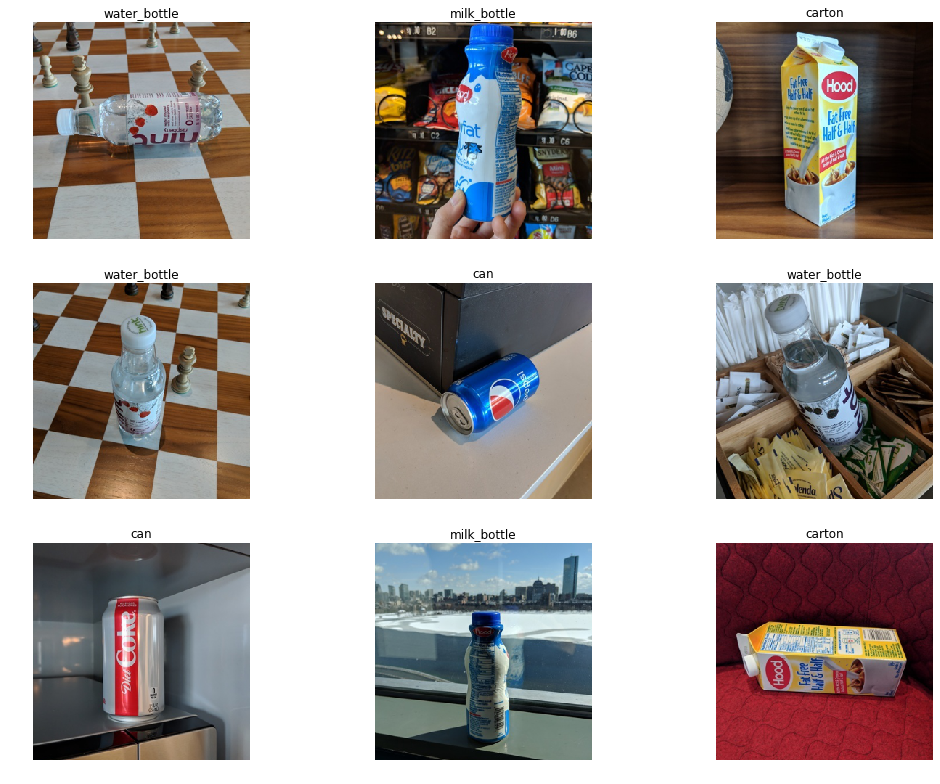

In [8]:
data.show_batch(rows=3, figsize=(15,11))

Lets see all available classes:

In [11]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


We can also see how many images we have in our training and validation set.

In [10]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (108 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
water_bottle,water_bottle,water_bottle,water_bottle,water_bottle
Path: /git/cvbp/image_classification/data/fridgeObjects;

Valid: LabelList (26 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
can,can,can,carton,carton
Path: /git/cvbp/image_classification/data/fridgeObjects;

Test: None>

Above, you'll notice that the validation set is 20% of the total images. 

You'll also notice that the test set will be set to `None`. This is because we treat it as a second holdout set that is only used right at the end of a project.

## Training

For the model, we use a concolutional neural network. 

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. 

With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and a performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train imagenet. 

In [12]:
learn = cnn_learner(data, ARCHITECTURE, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jumin/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 75444382.48it/s]


Unfreeze our CNN so that we're training all the layers.

In [13]:
learn.unfreeze()

In [14]:
learn.data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5a1cada630>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f5a1cbb7158>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f5a1d9d1840>)

We can call the `fit` function to train the dnn.

In [15]:
learn.fit(EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy,time
0,1.234772,1.290813,0.423077,00:30
1,0.799006,0.807927,0.653846,00:05
2,0.548963,0.476748,0.923077,00:05
3,0.415845,0.308087,1.000000,00:05
4,0.325239,0.219399,1.000000,00:05


## Evaluating

To evaluate our model, lets take a look at the accuracy on the validation set.

In [49]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {float(metric)}')

Accuracy on validation set: 1.0


When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [122]:
interp = ClassificationInterpretation.from_learner(learn)

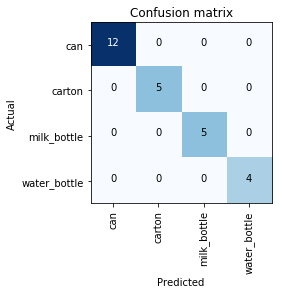

In [123]:
interp.plot_confusion_matrix()

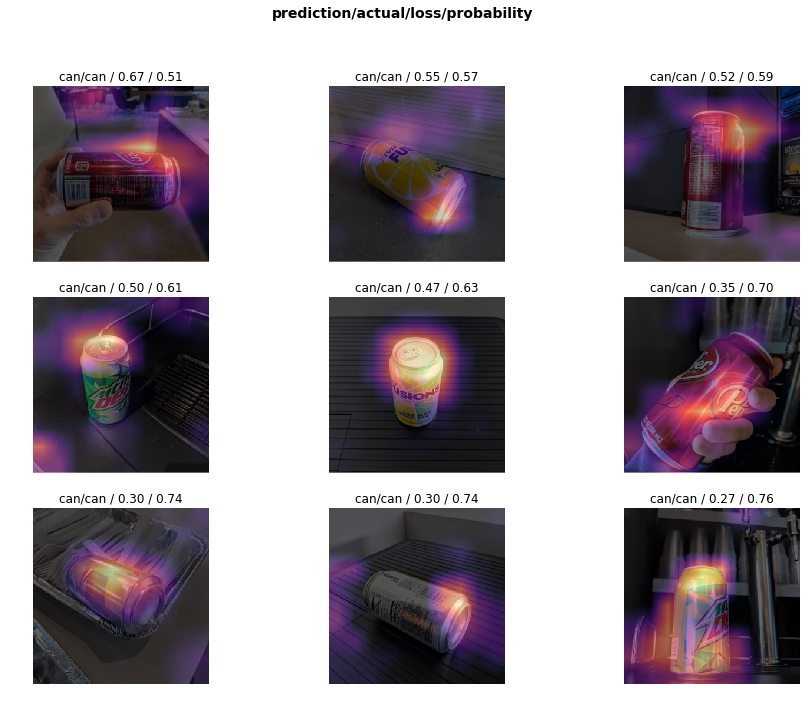

In [124]:
interp.plot_top_losses(9, figsize=(15,11))

In [133]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

"""
Image Classification results widget
"""
import bqplot
from bqplot import pyplot as bqpyplot
import fastai.data_block
from ipywidgets import widgets, Layout, IntSlider
import numpy as np


def _list_sort(list1d, reverse=False, comparison_fn=lambda x: x):
    """Sorts list1f and returns (sorted list, list of indices)"""
    indices = list(range(len(list1d)))
    tmp = sorted(zip(list1d, indices), key=comparison_fn, reverse=reverse)
    return list(map(list, list(zip(*tmp))))


class ResultsUI(object):
    def __init__(
        self,
        dataset: fastai.data_block.LabelList,
        pred_scores: iter,
        pred_labels: iter
    ):
        """Plot image classification results widget.

        Args:
            dataset (LabelList): Data used for prediction
            pred_scores (iterable): Prediction result scores
            pred_labels (iterable): Prediction result labels
        """
        assert (len(pred_scores) == len(pred_labels) == len(dataset))

        self.dataset = dataset
        self.pred_scores = pred_scores
        self.pred_labels = pred_labels

        # Init
        self.vis_image_index = 0
        self.labels = dataset.classes
        self.label_to_id = {s: i for i, s in enumerate(self.labels)}

        # Create UI
        self.ui = self.create_ui()

    # Update / redraw all UI elements
    def update_ui(self):
        pred_label = self.pred_labels[self.vis_image_index]
        scores = self.pred_scores[self.vis_image_index]
        im = self.dataset.x[self.vis_image_index]  # fastai Image object

        _, sort_order = _list_sort(scores, reverse=True)
        pred_labels_str = ""
        for i in sort_order:  # or may use up to 20 items e.g. [:min(20, len(sort_order))]:
            pred_labels_str += "{}({:3.1f}) \n".format(self.labels[i], scores[i])
        self.w_pred_labels.value = str(pred_labels_str)

        self.w_image_header.value = "Image index: {}".format(self.vis_image_index)
        self.w_img.value = im._repr_png_()
        self.w_gt_label.value = str(self.dataset.y[self.vis_image_index])
        self.w_pred_label.value = str(pred_label)
        self.w_pred_score.value = str(self.pred_scores[self.vis_image_index, self.label_to_id[pred_label]])
        self.w_index.value = str(self.vis_image_index)

        self.w_filename.value = str(self.dataset.items[self.vis_image_index].name)
        self.w_path.value = str(self.dataset.items[self.vis_image_index].parent)
        bqpyplot.clear()
        bqpyplot.bar(self.labels, scores, align='center', alpha=1.0, color=np.abs(scores),
                     scales={'color': bqplot.ColorScale(scheme='Blues', min=0)})

    # Create all UI elements
    def create_ui(self):

        # ------------
        # Callbacks + logic
        # ------------
        # Return if image should be shown
        def image_passes_filters(image_index):
            actual_label = str(self.dataset.y[image_index])
            bo_pred_correct = actual_label == self.pred_labels[image_index]
            if (bo_pred_correct and self.w_filter_correct.value) or (not bo_pred_correct and self.w_filter_wrong.value):
                return True
            return False

        # Next / previous image button callback
        def button_pressed(obj):
            step = int(obj.value)
            self.vis_image_index += step
            self.vis_image_index = min(max(0, self.vis_image_index), int(len(self.pred_labels)) - 1)
            while not image_passes_filters(self.vis_image_index):
                self.vis_image_index += step
                if self.vis_image_index <= 0 or self.vis_image_index >= int(len(self.pred_labels)) - 1:
                    break
            self.vis_image_index = min(max(0, self.vis_image_index), int(len(self.pred_labels)) - 1)
            self.w_image_slider.value = self.vis_image_index
            self.update_ui()

        # Image slider callback. Need to wrap in try statement to avoid errors when slider value is not a number.
        def slider_changed(obj):
            try:
                self.vis_image_index = int(obj['new']['value'])
                self.update_ui()
            except Exception as e:
                pass

        # ------------
        # UI - image + controls (left side)
        # ------------
        self.w_pred_labels = widgets.Textarea(value="", description="Predictions:") #, width='400px')
        self.w_pred_labels.layout.height = '300px'
        self.w_pred_labels.layout.width = '400px'
        
        w_next_image_button = widgets.Button(description="Image +1")
        w_next_image_button.value = "1"
        w_next_image_button.layout = Layout(width='80px')
        w_next_image_button.on_click(button_pressed)
        w_previous_image_button = widgets.Button(description="Image -1")
        w_previous_image_button.value = "-1"
        w_previous_image_button.layout = Layout(width='80px')
        w_previous_image_button.on_click(button_pressed)

        self.w_image_slider = IntSlider(min=0, max=len(self.pred_labels) - 1, step=1,
                                        value=self.vis_image_index, continuous_update=False)
        self.w_image_slider.observe(slider_changed)
        self.w_image_header = widgets.Text("", layout=Layout(width="130px"))
        self.w_img = widgets.Image()
        self.w_img.layout.width = '500px'
        w_image_with_header = widgets.VBox(children=[widgets.HBox(children=[w_previous_image_button, w_next_image_button, self.w_image_slider]),
                                                  self.w_img, self.w_pred_labels], width=520)

        # ------------
        # UI - info (right side)
        # ------------
        w_filter_header = widgets.HTML(value="Filters (use Image +1/-1 buttons for navigation):")
        self.w_filter_correct = widgets.Checkbox(value=True, description='Correct classifications')
        self.w_filter_wrong = widgets.Checkbox(value=True, description='Incorrect classifications')

        w_gt_header = widgets.HTML(value="Ground truth:")
        self.w_gt_label = widgets.Text(value="", description="Label:")

        w_pred_header = widgets.HTML(value="Prediction:")
        self.w_pred_label = widgets.Text(value="", description="Label:")
        self.w_pred_score = widgets.Text(value="", description="Score:")

        w_info_header = widgets.HTML(value="Image info:")
        self.w_index = widgets.Text(value="", description="Index:")
        self.w_filename = widgets.Text(value="", description="Name:")
        self.w_path = widgets.Text(value="", description="StoragePath:")

        w_scores_header = widgets.HTML(value="Classification scores:")
        self.w_scores = bqpyplot.figure()
        self.w_scores.layout.height = '250px'
        self.w_scores.layout.width = '370px'
        self.w_scores.fig_margin = {"top": 5, "bottom": 80, "left": 30, "right": 5}

        # Combine UIs into tab widget
        w_info_HBox = widgets.VBox(children=[w_filter_header, self.w_filter_correct, self.w_filter_wrong, w_gt_header,
                                           self.w_gt_label, w_pred_header, self.w_pred_label, self.w_pred_score,
                                           w_info_header, self.w_index, self.w_filename, self.w_path, w_scores_header,
                                           self.w_scores])
        w_info_HBox.layout.padding = '20px'
        vis_tabs_ui = widgets.Tab(children=[widgets.HBox(children=[w_image_with_header, w_info_HBox])])  # ,
        vis_tabs_ui.set_title(0, 'Results viewer')

        # Fill UI with content
        self.update_ui()

        return (vis_tabs_ui)


In [125]:
# Get predictions and target labels on 
preds = learn.get_preds(ds_type=DatasetType.Valid)
data = learn.data.valid_ds

In [134]:
results_ui = ResultsUI(
    data,
    preds[0],
    [data.classes[x] for x in np.argmax(to_np(preds[0]), axis=1)]
)
display(results_ui.ui)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


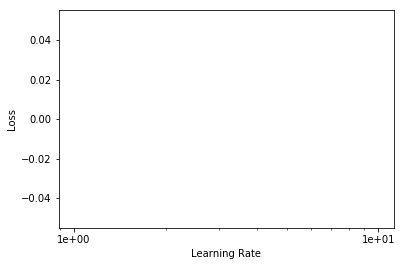

In [137]:
learn.lr_find()
learn.recorder.plot()


In [138]:
learn.recorder.plot_metrics()

AssertionError: There are no metrics to plot.

In [ ]:
# TODO # Precision / recall curve UI, ROC curve